# Healthy Pandas Code 

## Notebook Setup & Imports

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

import folium
import seaborn as sns
from scipy import stats
import json

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict

from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import re
from PIL import Image
from IPython.display import Image as im

from nltk.draw.dispersion import dispersion_plot

In [2]:
#!pip install gensim==3.6.0
#! conda list| findstr gensim
#!pip install wordcloud

In [3]:
dataset = 'winemag-data-130k-v2.csv'

In [4]:
df = pd.read_csv(dataset, index_col = 'Unnamed: 0')

# Data Cleaning


In [6]:
df = df.dropna(subset=["country", "description", "points", "price", "province", "variety"]).reset_index().drop("index", axis=1)
df = df.drop_duplicates("description")
df["country"] = np.where(df["country"] == "US", "United States of America", df["country"])
df = df.drop(columns = ['designation','region_1','region_2','taster_name','taster_twitter_handle','title','winery'])
df

,country,description,points,price,province,variety
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling
3,United States of America,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot
...,...,...,...,...,...,...
111506,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Riesling
111507,United States of America,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Pinot Noir
111508,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Gewürztraminer
111509,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Pinot Gris


# Exploratory Data Analysis 

<AxesSubplot:xlabel='points'>

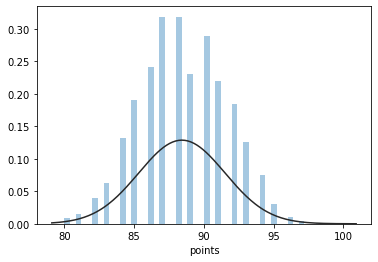

In [7]:
sns.distplot(df['points'], kde=False, fit=stats.norm)

<AxesSubplot:ylabel='Frequency'>

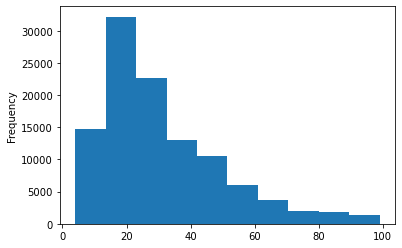

In [8]:
df[df['price'] < 100]['price'].plot.hist()

<AxesSubplot:xlabel='price', ylabel='points'>

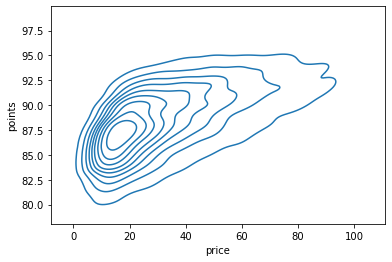

In [9]:
sns.kdeplot(data=df[df['price'] < 100].loc[:, ['price', 'points']].sample(10000), x='price', y='points')

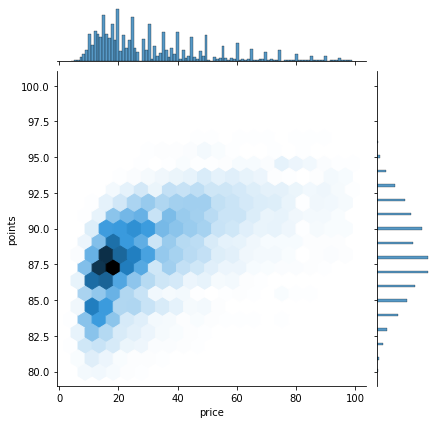

In [10]:
sns.jointplot(x='price', y='points', data=df[df['price'] < 100], kind='hex', gridsize=20)

<AxesSubplot:xlabel='variety', ylabel='points'>

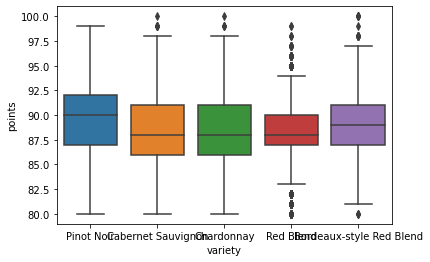

In [11]:
df_top_5 = df[df["variety"].isin(df["variety"].value_counts().head(5).index)]
sns.boxplot(data=df_top_5, x="variety", y="points")

<AxesSubplot:xlabel='points'>

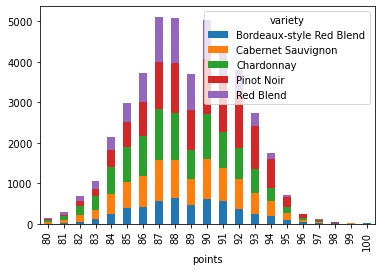

In [12]:
df_top_5[["points", "variety"]].value_counts().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='points', ylabel='description_length'>

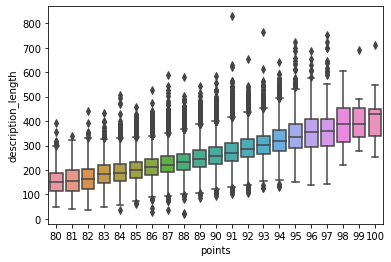

In [13]:
df["description_length"] = df["description"].apply(len)
sns.boxplot(data=df, x="points", y="description_length")


In [14]:

# JSON cleaning
with open("countries.json") as f:
    raw_countries_json = json.load(f)
countries_json = {"type": "FeatureCollection", "features" : []}
for feature in raw_countries_json["features"]:
    if feature["properties"]["name"] in df["country"].unique():
        countries_json["features"].append(feature)


In [15]:
m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=countries_json,
    data=df,
    columns=["country", "price"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name="Price",
).add_to(m)

folium.LayerControl().add_to(m)

m

# Sentimental Analysis 

In [16]:
headers = ['pos','neg','neu','compound']
texts = df["description"]
analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['description']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['description']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['description']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['description']]

In [17]:
df

,country,description,points,price,province,variety,description_length,compound,neg,neu,pos
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,227,0.6486,0.000,0.872,0.128
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,186,-0.1280,0.053,0.947,0.000
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,199,0.3400,0.000,0.930,0.070
3,United States of America,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,249,0.8176,0.000,0.817,0.183
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,261,0.1655,0.000,0.961,0.039
...,...,...,...,...,...,...,...,...,...,...,...
111506,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Riesling,227,0.7331,0.000,0.838,0.162
111507,United States of America,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Pinot Noir,233,0.5267,0.000,0.916,0.084
111508,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Gewürztraminer,225,0.1548,0.068,0.873,0.059
111509,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Pinot Gris,216,0.5267,0.000,0.896,0.104


## WordClouds

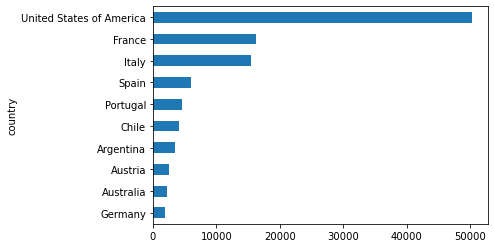

In [18]:
"""Looking at number of reviews by each country to select country with most reviews for word cloud generation """
df1 = df["country"]
num_of_reviews = df1.groupby(df["country"]).count()
num = num_of_reviews.sort_values(ascending=True)

"""Reviews of top 10 countries"""
reviews = num.tail(10)

bargraph = reviews.plot.barh(x='country', y='reviews[1]')

In [19]:
"""Specifiying stopwords for the reviews"""

stopwords_reviews = ["wine", "review", "drink", "bottle", "flavor", "well", 
                     "hint", "finish", "palate", "show", "now", "full",
                     "flavors", "shows", "fruit", "will", "give", "made"]
stopwords_updated = set(STOPWORDS)
stopwords_updated.update(stopwords_reviews)

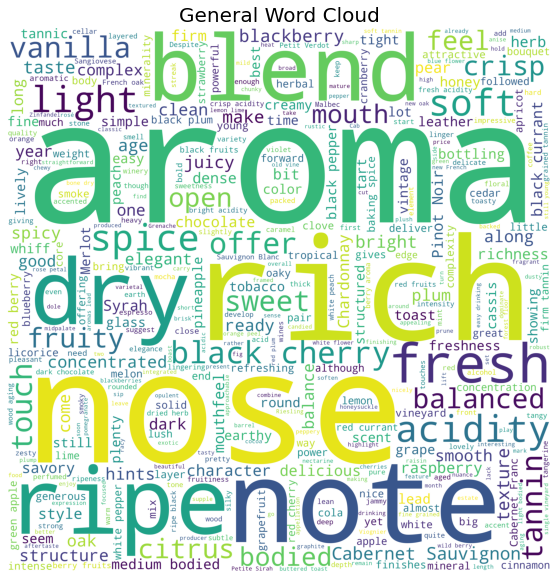

In [20]:
"""Making a general word cloud for all descriptions"""

%matplotlib inline

text = df['description'].astype(str)
wordcloud = WordCloud(stopwords=stopwords_updated,
                      background_color='white',
                      width=3000,height=3000, 
                      max_words=400).generate(" ".join(text)) 

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.title("General Word Cloud",fontsize=20)
plt.axis('off')
plt.show()

In [21]:
"""Using a default dictionary to add all descriptions for every specific country together"""

descriptions = defaultdict(list)
df.apply(lambda words: descriptions[words.country].append(words.description), axis=1)

country_list = list(df.country.unique())
for country in country_list:
    string = ' '.join(descriptions[country])
    descriptions[country] = ' '.join([word.lower() for word in re.sub(re.compile('[^A-Za-z ]+'), ' ', string).split()])

In [22]:
"Making a dictionary with country name as key and file path to base image as value"
base = {}

base['United States of America'] = "usa_bw_map.jpg"
base['France'] = "france_bw_map.jpg"
base['Italy'] = "italy_bw_map.jpg"
base['Spain'] = "spain_bw_map.jpg"
base['Portugal'] = "portugal_bw_map.jpg"
base['Chile'] = "chile_bw_map.jpg"
base['Argentina'] = "argentina_bw_map.jpg"
base['Austria'] = "austria_bw_map.jpg"
base['Australia'] = "australia_bw_map.jpg"
base['Germany'] = "germany_bw_map.jpg"

In [23]:
def country_wordcloud(reviews_country, base_image):
    base = np.array(Image.open(base_image))
    wordcloud = WordCloud(background_color="white", max_words=400, mask=base, 
                   stopwords=stopwords_updated, colormap='jet').generate(reviews_country)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

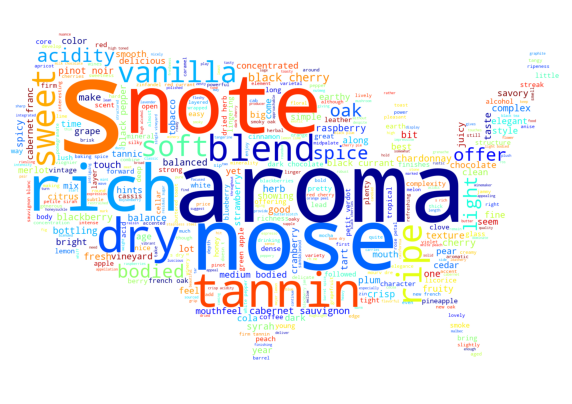

In [24]:
reviews_country = descriptions['United States of America']
wordcloud = country_wordcloud(reviews_country, base['United States of America'])

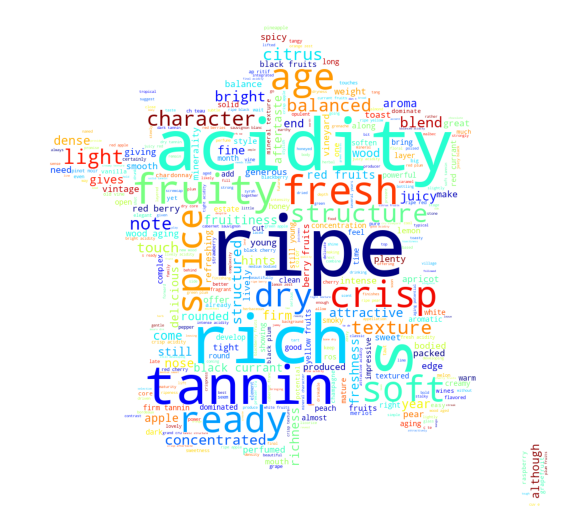

In [25]:
reviews_country = descriptions['France']
wordcloud = country_wordcloud(reviews_country, base['France'])


In [ ]:
reviews_country = descriptions['Italy']
wordcloud = country_wordcloud(reviews_country, base['Italy'])

In [ ]:
reviews_country = descriptions['Spain']
wordcloud = country_wordcloud(reviews_country, base['Spain'])

In [ ]:
reviews_country = descriptions['Portugal']
wordcloud = country_wordcloud(reviews_country,base ['Portugal'])


In [ ]:
reviews_country = descriptions['Chile']
wordcloud = country_wordcloud(reviews_country, base['Chile'])

In [ ]:
reviews_country = descriptions['Argentina']
wordcloud = country_wordcloud(reviews_country, base['Argentina'])


In [ ]:
reviews_country = descriptions['Austria']
wordcloud = country_wordcloud(reviews_country, base['Austria'])

In [ ]:
words = descriptions['Australia']
wordcloud = country_wordcloud(reviews_country, base['Australia'])

In [ ]:
words = descriptions['Germany']
wordcloud = country_wordcloud(reviews_country, base['Germany'])

# Topic modelling

In [30]:
texts = [[word for word in desc.lower().split() if word not in STOPWORDS and word.isalnum() and not word.lower() in ['wine', 'drink']] for desc in list(df["description"].values)]
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence


In [31]:

num_topics = 5 #The number of topics that should be generated
passes = 10
lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes)


In [32]:

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=10))

[   (   0,
        '0.017*"ripe" + 0.017*"fruit" + 0.016*"rich" + 0.016*"tannins" + '
        '0.014*"will" + 0.012*"black" + 0.011*"acidity" + 0.011*"red" + '
        '0.010*"well" + 0.009*"fruits"'),
    (   1,
        '0.030*"aromas" + 0.025*"white" + 0.023*"palate" + 0.017*"offers" + '
        '0.013*"fruit" + 0.012*"bright" + 0.010*"fresh" + 0.009*"pair" + '
        '0.009*"opens" + 0.008*"stone"'),
    (   2,
        '0.044*"flavors" + 0.027*"aromas" + 0.018*"finish" + 0.014*"fruit" + '
        '0.014*"cherry" + 0.012*"berry" + 0.011*"oak" + 0.011*"plum" + '
        '0.011*"bit" + 0.010*"palate"'),
    (   3,
        '0.038*"black" + 0.026*"aromas" + 0.023*"palate" + 0.018*"tannins" + '
        '0.018*"cabernet" + 0.018*"red" + 0.017*"cherry" + 0.014*"offers" + '
        '0.013*"dried" + 0.013*"dark"'),
    (   4,
        '0.025*"flavors" + 0.019*"acidity" + 0.018*"apple" + 0.016*"citrus" + '
        '0.015*"crisp" + 0.013*"fresh" + 0.013*"lemon" + 0.012*"notes" + '
        '0.01

# One-hot coding

In [33]:
country_array = pd.get_dummies(df[df.columns[0]].values)
province_array =pd.get_dummies(df[df.columns[4]].values)
vareity_array = pd.get_dummies(df[df.columns[5]].values)

In [34]:
train_df = [df['price'],df['compound'],df['neg'],df['neu'],df['pos'],country_array,province_array,vareity_array,df['points']]
df_model = pd.concat(train_df, axis=1)

In [35]:
df_model.dropna(inplace = True)

In [36]:
df_model

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka,points
0,15.0,0.6486,0.000,0.872,0.128,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
1,14.0,-0.1280,0.053,0.947,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
2,13.0,0.3400,0.000,0.930,0.070,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
3,65.0,0.8176,0.000,0.817,0.183,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
4,15.0,0.1655,0.000,0.961,0.039,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111506,28.0,0.7331,0.000,0.838,0.162,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90
111507,75.0,0.5267,0.000,0.916,0.084,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90
111508,30.0,0.1548,0.068,0.873,0.059,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90
111509,32.0,0.5267,0.000,0.896,0.104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90


# Correlation


In [37]:
from scipy.stats import pearsonr
print("Pearson Correlation:", pearsonr(df.price, df.points))

Pearson Correlation: PearsonRResult(statistic=0.416593665287773, pvalue=0.0)


In [38]:
import statsmodels.api as sm
print(sm.OLS(df.points, df.price).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.431
Method:                 Least Squares   F-statistic:                          8.450e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:23:04   Log-Likelihood:                     -6.2664e+05
No. Observations:              111511   AIC:                                  1.253e+06
Df Residuals:                  111510   BIC:                                  1.253e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

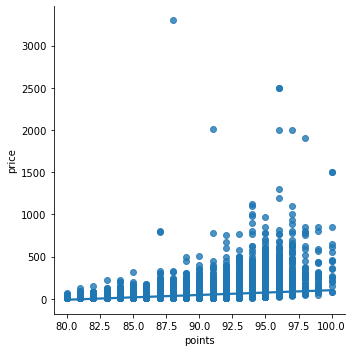

In [39]:
import seaborn as sns
sns.lmplot(y = 'price', x='points', data=df)

# Split 

In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']
x_train

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
95183,45.0,0.3400,0.029,0.895,0.076,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25111,13.0,0.6908,0.000,0.867,0.133,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
91500,16.0,0.8360,0.000,0.797,0.203,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7468,15.0,0.7089,0.000,0.852,0.148,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101005,45.0,0.8564,0.000,0.797,0.203,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33325,14.0,0.0000,0.000,1.000,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1895,15.0,-0.1280,0.059,0.941,0.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33760,42.0,0.3612,0.000,0.957,0.043,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15841,37.0,0.7845,0.000,0.853,0.147,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [60]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.LinearRegression()
model.fit(x_train,y_train)
model.coef_

array([ 8.01595950e-02,  3.97065849e+00,  5.72292714e+01, ...,
       -3.26016718e+06, -3.26017053e+06, -3.26017092e+06])

In [61]:
from sklearn.metrics import r2_score
import math
training_predictions = model.predict(x_train)
testing_predictions  = model.predict(x_test)
#r2_score(y_test, testing_predictions)
mse = mean_squared_error(y_test, testing_predictions)
rmse = math.sqrt(mse)
mse
#metrics.accuracy_score(y_test, y_pred)

25097462584423.22

In [62]:
print("Training R-Square",model.score(x_train,y_train))
print("Testing R-Square",model.score(x_test,y_test))

Training R-Square 0.3983929879986058
Testing R-Square -2911051368674.513


In [63]:

r2_score(y_test, testing_predictions)


-2911051368674.513

# Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logit = LogisticRegression()
logit.fit(x_train,y_train)
y_pred = logit.predict(x_test)


In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

2.4740845264762625

In [66]:
r2_score(y_test, y_pred)

0.29001508749008653

In [68]:
#from sklearn import metrics
#metrics.accuracy_score(y_test, y_pred)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


for i in range(10,30):
    dt_model = tree.DecisionTreeRegressor(max_depth=i)
#model = DecisionTreeRegressor(max_depth = 3)
    print(i,dt_model.fit(x_train,np.ravel(y_train)),dt_model.score(X=x_test, y=y_test))
y_pred =dt_model.predict(x_test)

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
dt_model = tree.DecisionTreeRegressor(max_depth=17)
dt_model.fit(x_train,np.ravel(y_train))
dt_model.score(X=x_test, y=y_test)
y_pred =dt_model.predict(x_test)
#metrics.accuracy_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4133633467873823
0.3244375862191127


In [ ]:
accuracy_score(y_test, y_pred)

# RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=20,min_samples_leaf=10,min_samples_split=10,n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.522391814936409
0.2639876218417384


In [77]:
y_pred =rf_model.predict(x_test).round()
accuracy_score(y_test, y_pred)

0.16192970365265336

# BaggingClassifier

In [72]:
from sklearn.ensemble import BaggingClassifier
b_model=BaggingClassifier()
b_model.fit(x_train,np.ravel(y_train))
y_pred =b_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.629450535792051
0.19804487980909335


In [79]:
accuracy_score(y_test, y_pred)

0.19354927636113026

# KNN

In [73]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train,y_train)
knn.score(x_test, y_test)

y_pred =knn.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4691413642264064
0.29284931935282754


In [38]:
mse = mean_squared_error(y_test, knn.predict(x_test))
rmse = math.sqrt(mse)
rmse

2.4199868428938744

In [103]:
accuracy_score(y_test, knn.predict(x_test).round())

0.17739490006891798

# Making Points Categorical

In [54]:
# Assign levels base on points of the wine to make points categorical data
for i in df_model['points']:
    if i > 95:
        df_model['level'] = 'A'
    elif i < 95 and i>= 90:
        df_model['level'] = 'B'
    elif i < 90 and i >= 85:
        df_model['level'] = 'C'
    elif i < 85 and i>= 80:
        df_model['level'] = 'D'


In [57]:
df_classif = df_model

# Split data

In [68]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_classif, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']
y_train

69292     85.0
81157     84.0
53668     88.0
89058     92.0
100898    87.0
          ... 
101437    83.0
102959    91.0
63579     93.0
79202     90.0
17289     94.0
Name: points, Length: 73778, dtype: float64

# RandomForestClassifier

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))
accuracy_score(y_test, y_pred)

0.6080318411050497
0.9573852134621372


0.9022770398481973

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model2 = SVC(kernel='linear', C=10) # kernel and C are the main args to adjust for linear SVC
model2.fit(x_train, y_train)
model2.score(x_train, y_train)

# Recommendation system

In [ ]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [ ]:
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)


In [ ]:

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)



In [ ]:

for n in range(3):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')